In [25]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.getcwd()

'/aiffel/aiffel/kaggle_kakr_housing'

In [26]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [27]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [28]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [29]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [30]:
# test 데이터에서 불필요한 'id' 컬럼 제거
del test['id']

# 'date' 컬럼 처리 (연도와 월 정보만 추출)
test['date'] = test['date'].apply(lambda i: int(i[:6]))

# 결과 확인
print(test.columns)
print(test.head())

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
     date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201412         3       2.25         2570      7242     2.0           0   
1  201412         4       3.00         1960      5000     1.0           0   
2  201405         4       4.50         5420    101930     1.0           0   
3  201504         3       1.00         1780      7470     1.0           0   
4  201503         3       2.50         1890      6560     2.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        2170            400      1951          1991   
1     0          5      7        1050            910      1965             0   
2     0         

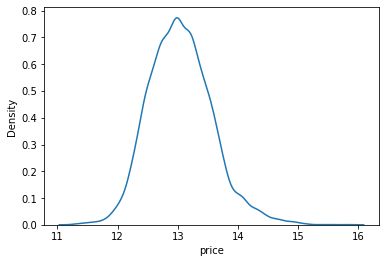

In [35]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [ ]:
data.head()

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

In [31]:
msno.matrix(data)

NameError: name 'data' is not defined

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [ ]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [ ]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

In [ ]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [ ]:
## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [37]:
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import numpy as np

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=42)

# 앙상블 모델 구성
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

base_learners = [
    ('xgb', XGBRegressor(n_estimators=100, max_depth=3, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=100, max_depth=3, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42))
]

stack_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=LGBMRegressor(n_estimators=100, max_depth=3, random_state=42)
)

# 모델 학습
stack_model.fit(X_train, y_train)

# 예측 및 RMSLE 계산
y_pred = stack_model.predict(X_val)
rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(y_pred)))
print(f"RMSLE: {rmsle:.6f}")


RMSLE: 0.175662


In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'xgb__n_estimators': [50, 100],
    'lgbm__n_estimators': [50, 100],
    'gbr__n_estimators': [50, 100],
}

grid_search = GridSearchCV(estimator=stack_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_log_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


Best parameters: {'gbr__n_estimators': 50, 'lgbm__n_estimators': 100, 'xgb__n_estimators': 100}


In [41]:
# 최적 모델로 예측
y_pred_best = best_model.predict(X_val)
rmsle_best = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(y_pred_best)))
print(f"최적화된 RMSLE: {rmsle_best:.6f}")


최적화된 RMSLE: 0.174896


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


KeyboardInterrupt: 

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [42]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [44]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.16499')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.16499.csv
[CV] END gbr__n_estimators=50, lgbm__n_estimators=50, xgb__n_estimators=50; total time=  30.4s
[CV] END gbr__n_estimators=50, lgbm__n_estimators=50, xgb__n_estimators=50; total time=  55.5s
[CV] END gbr__n_estimators=50, lgbm__n_estimators=50, xgb__n_estimators=100; total time=  23.5s
[CV] END gbr__n_estimators=50, lgbm__n_estimators=100, xgb__n_estimators=50; total time=  36.3s
[CV] END gbr__n_estimators=50, lgbm__n_estimators=100, xgb__n_estimators=50; total time=  36.2s
[CV] END gbr__n_estimators=50, lgbm__n_estimators=100, xgb__n_estimators=100; total time=  23.0s
[CV] END gbr__n_estimators=100, lgbm__n_estimators=50, xgb__n_estimators=50; total time=  37.1s
[CV] END gbr__n_estimators=100, lgbm__n_estimators=50, xgb__n_estimators=50; total time=  28.5s
[CV] END gbr__n_estimators=100, lgbm__n_estimators=50, xgb__n_estimators=100; total time=  48.3s
[CV] END gbr__n_estimators=100, lgbm__n_estimators=100, xgb__n

![이미지 설명](https://i.ibb.co/PrDmz04/Kakao-Talk-20250113-171549570.png)


In [ ]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [ ]:
sub.to_csv('submission.csv', index=False)